### To run Model all required code modules are marked with "*"

# Imports and Global Variables *

This notebook demonstrates various image enhancement techniques using OpenCV.

In [1]:
#imports
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
import time
import torch.nn.functional as F

# Dataset directory
Dataset_path = "E:/Github/UTMIST-OpenCV-Image-Enchancement/Dataset4K"

## Testing that Data Exists and can be displayed

We will start by loading an image from the disk.

In [ ]:
image = cv2.imread("dataset4k/4k-3840-x-2160-wallpapers-themefoxx (1).jpg")

if image is None:
  print("image not found -- check to see if dataset path is correct or dataset is downloaded.")
else:
  print("image found")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

half = cv2.resize(image, (0, 0), fx = 0.1, fy = 0.1)
plt.imshow(cv2.cvtColor(half, cv2.COLOR_BGR2RGB))
plt.title('Resized Image')
plt.show()

image found


## Storing and Creating a Training Dataset - i.e Downscaling Images - Test


In [ ]:
for each in Path(Dataset_path).iterdir():
  if each.is_file() and each.suffix in ['.jpg', '.jpeg', '.png']:
    image = cv2.imread(str(each))
    if image is not None:
      downscaled_image = cv2.resize(image, (0, 0), fx=0.25, fy=0.25)
      output_path = Path("E:/Github/UTMIST-OpenCV-Image-Enchancement/Downscaled_Dataset") / each.name
      cv2.imwrite(str(output_path), downscaled_image)
      print(f"Saved downscaled image to {output_path}")
    else:
      print(f"Failed to read image {each}")

## Load Data into Tensors/Data Types - Decomissioned

In [ ]:
def load_and_normalize_images(image_dir, normalize_range=(0, 1), target_size=(480, 270)):
    image_paths = list(Path(image_dir).glob('*'))
    images = []
    
    for image_path in image_paths:
        image = cv2.imread(str(image_path))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image.astype(np.float32)
            if normalize_range == (0, 1):
                image /= 255.0
            elif normalize_range == (-1, 1):
                image = (image / 127.5) - 1.0
            images.append(image)
        else:
            print(f"Failed to read image {image_path}")
    
    return np.array(images)

# Load and normalize images from Downscaled_Dataset
downscaled_images = load_and_normalize_images("E:/Github/UTMIST-OpenCV-Image-Enchancement/Downscaled_Dataset", normalize_range=(0, 1))
print(f"Loaded {len(downscaled_images)} images from Downscaled_Dataset")

Loaded 2056 images from Downscaled_Dataset


## Model Architecture for Residual Blocks and 3x3 Conv. v ReLu Layer*

In [2]:
# Super-resolution dataset definition.
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, transform=None, downscale_factor=4, target_height=1440):
        """
        hr_dir: Directory containing the original 4K images.
        transform: A torchvision.transforms pipeline for image conversion.
        downscale_factor: Factor by which the image is downscaled to simulate low resolution.
        target_height: The height (in pixels) to which images will be scaled (maintaining aspect ratio).
        """
        self.hr_dir = hr_dir
        self.image_files = [os.path.join(hr_dir, file) for file in os.listdir(hr_dir)
                            if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        self.downscale_factor = downscale_factor
        self.target_height = target_height

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        t0 = time.time()
    
        # Load and convert image.
        hr_img = cv2.imread(self.image_files[index])
        if hr_img is None:
            raise ValueError(f"Image not found or cannot be read: {self.image_files[index]}")
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    
        # Scale down to target resolution (1440p height) if the image is larger.
        orig_h, orig_w, _ = hr_img.shape
        if orig_h > self.target_height:
            scale_factor = self.target_height / orig_h
            target_w = int(orig_w * scale_factor)
            hr_img = cv2.resize(hr_img, (target_w, self.target_height), interpolation=cv2.INTER_AREA)
    
        # Update h, w after scaling.
        h, w, _ = hr_img.shape
        t1 = time.time()
    
        # Create the low-resolution (LR) image by downscaling.
        # Note: We do NOT upscale it back here.
        lr_img = cv2.resize(hr_img, (w // self.downscale_factor, h // self.downscale_factor), interpolation=cv2.INTER_CUBIC)
        t2 = time.time()
    
        # Apply transforms if provided.
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        t3 = time.time()
        
        print(f"Read & Color Conversion: {t1-t0:.4f}s, Downscale: {t2-t1:.4f}s, Transform: {t3-t2:.4f}s")
        return lr_img, hr_img

# Define transforms: convert images to tensors.
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add normalization if required.
])

# Specify your high-resolution images directory.
hr_images_dir = r"E:/Github/UTMIST-OpenCV-Image-Enchancement/Dataset4K"
dataset = SuperResolutionDataset(hr_dir=hr_images_dir, transform=transform, downscale_factor=4, target_height=1440)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Residual Block: 3x3 Conv -> ReLU -> BatchNorm -> 3x3 Conv -> BatchNorm with skip connection.
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu  = nn.ReLU(inplace=True)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x  # Save input for the skip connection.
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Skip connection.
        out = self.relu(out)
        return out

# Super-resolution network using residual blocks and PixelShuffle for upsampling.
class SuperResolutionNet(nn.Module):
    def __init__(self, num_channels=3, num_features=64, num_res_blocks=5, upscale_factor=4):
        """
        num_channels: Number of channels in the image (3 for RGB).
        num_features: Number of features after the initial convolution.
        num_res_blocks: Number of residual blocks.
        upscale_factor: Factor to upscale the input image.
        """
        super(SuperResolutionNet, self).__init__()
        
        # Step 1: Feature Extraction.
        self.initial_conv = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
        # Step 2: Residual Blocks.
        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(num_features))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Step 3: Upsampling using sub-pixel convolution (PixelShuffle).
        self.upsample_conv = nn.Conv2d(num_features, num_features * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        # Step 4: Post-processing: Final convolution to refine output.
        self.final_conv = nn.Conv2d(num_features, num_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # Extract low-level features.
        out = self.initial_conv(x)
        out = self.relu(out)
        
        # Process with residual blocks.
        out = self.res_blocks(out)
        
        # Upsample.
        out = self.upsample_conv(out)
        out = self.pixel_shuffle(out)
        
        # Final refinement.
        out = self.final_conv(out)
        return out


## Training *

In [ ]:

# Training settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperResolutionNet(num_channels=3, num_features=64, num_res_blocks=5, upscale_factor=4).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  # Adjust the number of epochs as needed.
# Training loop.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (lr_img, hr_img) in enumerate(dataloader):
        # Move images to the device.
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)
        
        # Forward pass.
        outputs = model(lr_img)

        # If output size does not match target, pad it
        if outputs.shape != hr_img.shape:
            padding = (
                0, hr_img.shape[3] - outputs.shape[3],  # Padding for width
                0, hr_img.shape[2] - outputs.shape[2]   # Padding for height
            )
            outputs = F.pad(outputs, padding)

        loss = criterion(outputs, hr_img)
        
        # Backward pass and optimization.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

# Save the trained model.
torch.save(model.state_dict(), "super_resolution_model.pth")
print("Training completed and model saved as 'super_resolution_model.pth'")


Read & Color Conversion: 0.1202s, Downscale: 0.0025s, Transform: 0.0123s
Read & Color Conversion: 0.0529s, Downscale: 0.0010s, Transform: 0.0106s
Read & Color Conversion: 0.0523s, Downscale: 0.0005s, Transform: 0.0116s
Read & Color Conversion: 0.0525s, Downscale: 0.0000s, Transform: 0.0131s
Read & Color Conversion: 0.0646s, Downscale: 0.0000s, Transform: 0.0141s
Read & Color Conversion: 0.1046s, Downscale: 0.0000s, Transform: 0.0127s
Read & Color Conversion: 0.0715s, Downscale: 0.0010s, Transform: 0.0131s
Read & Color Conversion: 0.0780s, Downscale: 0.0010s, Transform: 0.0133s
Read & Color Conversion: 0.0519s, Downscale: 0.0010s, Transform: 0.0126s
Read & Color Conversion: 0.0925s, Downscale: 0.0005s, Transform: 0.0116s
Epoch [1/1], Step [10/2056], Loss: 0.1797
Read & Color Conversion: 0.0639s, Downscale: 0.0000s, Transform: 0.0126s
Read & Color Conversion: 0.0634s, Downscale: 0.0000s, Transform: 0.0126s
Read & Color Conversion: 0.0508s, Downscale: 0.0000s, Transform: 0.0116s
Read & Co

KeyboardInterrupt: 

## Run the Saved Model

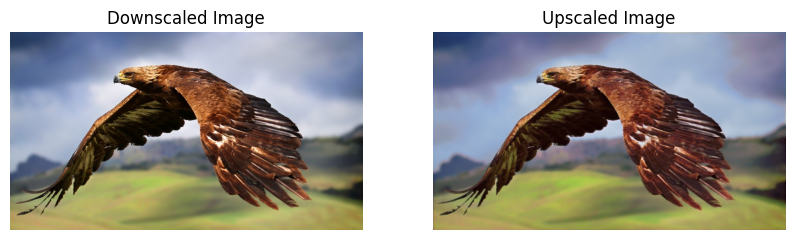

Upscaled image saved as 'upscaled_image.jpg'.


In [12]:
# Downscale an image to a given resolution
def downscale_image(image_path, target_height=1440):
    # Load the image.
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image to target resolution (keeping aspect ratio).
    orig_h, orig_w, _ = image.shape
    scale_factor = target_height / orig_h
    target_w = int(orig_w * scale_factor)
    downscaled_image = cv2.resize(image, (target_w, target_height))
    
    return downscaled_image

# Perform inference with the trained super-resolution model.
def upscale_image(model, image, device):
    # Convert the image to tensor and move to the device.
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        # Perform super-resolution.
        enhanced_image = model(image_tensor)

    # Convert the output tensor back to a NumPy array.
    enhanced_image = enhanced_image.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU.
    enhanced_image = np.transpose(enhanced_image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C).
    enhanced_image = (enhanced_image * 255).clip(0, 255).astype(np.uint8)

    return enhanced_image

# Main script.
if __name__ == "__main__":
    # Load the trained model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SuperResolutionNet(num_channels=3, num_features=64, num_res_blocks=5, upscale_factor=4).to(device)
    model.load_state_dict(torch.load("super_resolution_model.pth"))
    model.eval()  # Set to evaluation mode.

    # Path to the 4K image to downscale.
    input_image_path = "E:/Github/UTMIST-OpenCV-Image-Enchancement/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1).jpg"  # Replace with the path to your 4K image.
    
    # Step 1: Downscale the image to the input resolution.
    downscaled_image = downscale_image(input_image_path, target_height=480)

    # Step 2: Use the trained model to upscale the image.
    upscaled_image = upscale_image(model, downscaled_image, device)

    # Step 3: Display and save the results.
    plt.figure(figsize=(10, 5))

    # Show original downscaled image.
    plt.subplot(1, 2, 1)
    plt.imshow(downscaled_image)
    output_image_path = "Downscaled_image.jpg"  # Save the upscaled image.
    cv2.imwrite(output_image_path, cv2.cvtColor(downscaled_image, cv2.COLOR_RGB2BGR))
    plt.title("Downscaled Image")
    plt.axis('off')

    # Show upscaled image.
    plt.subplot(1, 2, 2)
    plt.imshow(upscaled_image)
    plt.title("Upscaled Image")
    plt.axis('off')

    plt.show()

    # Save the upscaled image.
    output_image_path = "upscaled_image.jpg"  # Save the upscaled image.
    cv2.imwrite(output_image_path, cv2.cvtColor(upscaled_image, cv2.COLOR_RGB2BGR))
    print(f"Upscaled image saved as '{output_image_path}'.")
